# Bayesian Gaussian Mixture Models


The GMM requires us to provide the number of clusters.

To determine the **optimal number of clusters** we use Bayesian information criterion (BIC) and the Akaike information criterion (AIC).

We train GMM with various values of $k$ and measure their BIC & AIC. We choose the optimal model (i.e., optimal $k$) based on the minimum BIC/AIC.

    It's a tedius and time-intensive process.

Instead of manually searching for the optimal number of clusters, we can use the **Bayesian GMM**. 

In the Bayesian model, we need to provide an upper bound for the number of clusters that we think the dataset might contain. Then, it automatically assigns weights equal (or close) to zero to unnecessary clusters. 


### How does the Bayesian GMM work?

Unlike the GMM, in Bayesian GMM the cluster parameters (including the weights, means, and covariance matrices) are not treated as fixed model parameters. These are considered as latent random variables. 

So, $z$ includes both the cluster parameters and the cluster assignments.

<img src="https://cse.unl.edu/~hasan/Pics/GMM-BayesianModel.png" width=800, height=600>

The parameters are modeled from the following distributions.

- The **Beta distribution** is commonly used to model random variables whose values lie within a fixed range. In this case, the range is from 0 to 1.

- The **Wishart distribution** is used to sample covariance matrices: the parameters $d$ and $V$ control the distribution of cluster shapes.

Bayesian models are based on prior knowledge. To describe the prior knowledge about the distribution of random variables, a **Dirichlet process** named the Stick-Breaking Process (SBP) is used. A Dirichlet process is a probability distribution whose range is itself a set of probability distributions.

The SBP determines how likely it is that the random variables are distributed according to one or another particular distribution.

SBP is best explained through an example. Suppose $\phi = [0.3, 0.6, 0.5...]$, then 30% of the instances will be assigned to cluster 0, then 60% of the remaining instances will be assigned to cluster 1, then 50% of the remaining instances will be assigned to cluster 2, and so on. This process is a good model for datasets where new instances are more likely to join large clusters than small clusters (e.g., people are more likely to move to larger cities). If the concentration $\alpha$ is high, then $\phi$ values will likely be close to 0, and the SBP generate many clusters. Conversely, if the concentration is low, then $\phi$ values will likely be close to 1, and there will be few clusters. 

## Tasks

- Task 1: Demonstration of automatic selection of optimal number of clusters
- Task 2: Demonstration of incorporating prior knowledge about the latent variables $z$ 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

## Synthetic Dataset

We will use Scikit-Learn's "make_blobs" function to generate isotropic Gaussian blobs for clustering.

We will create three clusters.

In [2]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

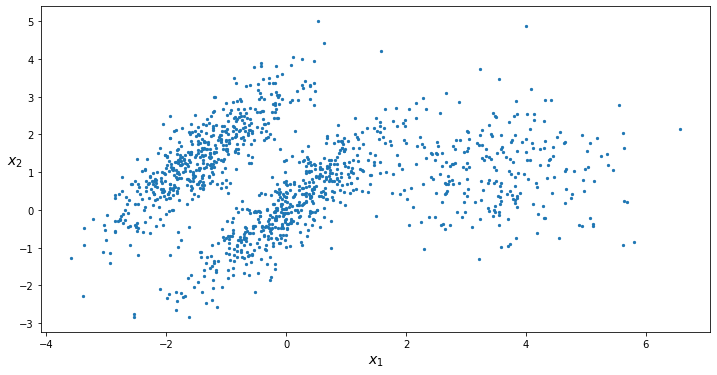

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap='autumn')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

## Task 1: Demonstration of Automatic Selection of Optimal Number of Clusters


Scikit-Learn provides the BayesianGaussianMixture class to create Bayesian GMM. We need to have some minimal knowledge about the problem. 

Based on this knowledge, we set the number of clusters n_components to a value that we have good reason to believe is greater than the optimal number of clusters. 

The algorithm will eliminate the **unnecessary clusters automatically**. 

In the following example, we set the the number of clusters to 10. We expect that the Bayesian GMM will select only three clusters.

In [4]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [5]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

## Task 1: Observation

The algorithm automatically detected only three clusters.

## Plot the Clusters & Density Regions


To visualize the density contours created by the GMM model, we use the following functions.

It also shows the cluster means and the decision boundaries (using dashed lines).

In [6]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

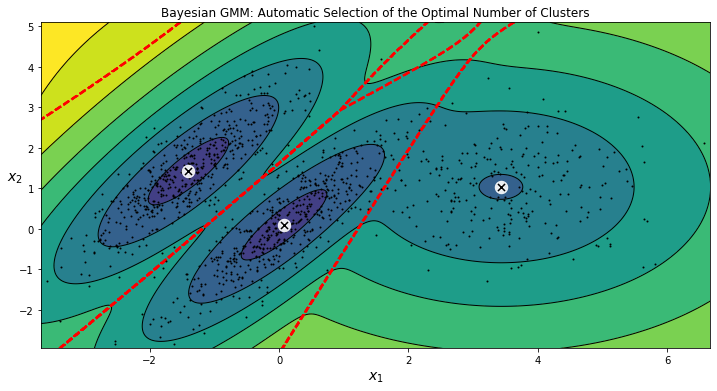

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Bayesian GMM: Automatic Selection of the Optimal Number of Clusters")
plot_gaussian_mixture(bgm, X)
plt.show()

## Task 2: Demonstration of Incorporating Prior Knowledge about the Latent Variables $z$ 

We may have a prior belief that the clusters are likely to be few (low concentration), or conversely, that they are likely to be plentiful (high concentration).

We can incorporate the prior knowledge about the latent variables $z$ in a probability distribution $p(z)$ called the prior. This prior belief about the number of clusters can be adjusted using the weight_concentration_prior hyperparameter. 

 

This hyperparameter provides the dirichlet concentration of each component on the weight distribution (Dirichlet). 

- A higher concentration puts more mass in the center and will lead to more components being active.
- A lower concentration parameter will lead to more mass at the edge of the mixture weights simplex. 



### Effect of Prior

To observe the effect of prior, we should use less data. The effect of prior would be subdued when we have a lot of data.

Thus, we vary the weight_concentration_prior hyperparameter between very small value (0.01) and a very large value (10,000) with **little data**.

In [8]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)


# We take a small subset of the data to observe the effect of the priors
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

## Task 2: Observation

We see that
- The model with low weight concentration creates only two clusters.
- The model with high weight concentration creates more (four) clusters.

In [9]:
print(np.round(bgm_low.weights_, 2))

print(np.round(bgm_high.weights_, 2))

[0.52 0.48 0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.01 0.18 0.27 0.11 0.01 0.01 0.01 0.01 0.37 0.01]


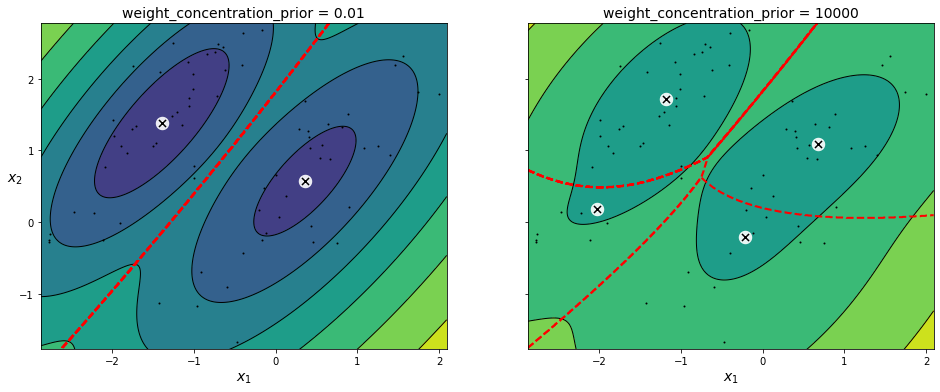

In [10]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

## Prior Subdued with More Data

We show that when we use **a lot of data**, the effect of prior is subdued.

We use the entire dataset to train two models.

Both models discover **similar clusters**.

In [11]:
bgm_low_moredata = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high_moredata = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)

bgm_low_moredata.fit(X)
bgm_high_moredata.fit(X)

print(np.round(bgm_low_moredata.weights_, 2))

print(np.round(bgm_high_moredata.weights_, 2))

[0.1  0.4  0.39 0.   0.1  0.   0.   0.   0.   0.  ]
[0.   0.4  0.39 0.   0.2  0.   0.   0.   0.   0.  ]


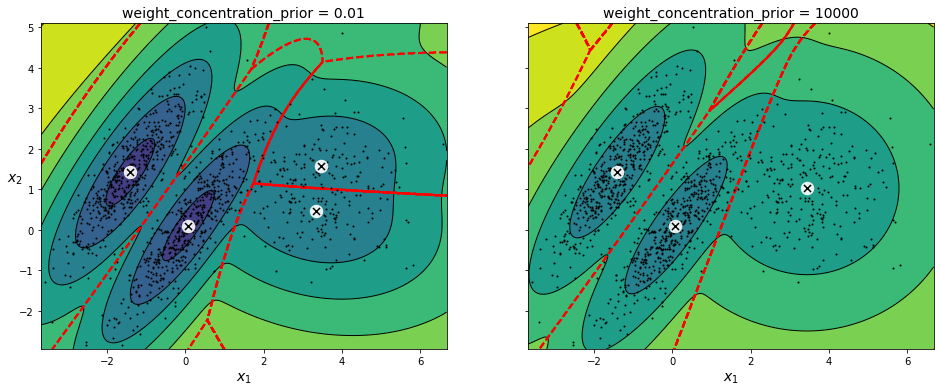

In [12]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plot_gaussian_mixture(bgm_low_moredata, X)
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high_moredata, X, show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()